In [23]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt 
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from tqdm import tqdm_notebook as tqdm
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [24]:
try:
    import dill as pickle
except ImportError:
    import pickle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# load doc into memory
def load_doc(filename): 
    file = open(filename, 'r') 
    text = file.read() 
    file.close()
    return text

basedir = "/content/drive/My Drive/"
filename = basedir + "Flickr8k_text/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [16]:
def load_descriptions(doc):
    mapping = dict()
    
    for line in doc.split('\n'):
        
        if len(line) < 2:
            continue
        tokens = line.split()
        
        image_id, image_desc = tokens[0], tokens[1:]
        
        image_id = image_id.split('.')[0]
        
        image_desc = ' '.join(image_desc)
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [17]:
list(descriptions.items())[:1]

[('1000268201_693b08cb0e',
  ['A child in a pink dress is climbing up a set of stairs in an entry way .',
   'A girl going into a wooden building .',
   'A little girl climbing into a wooden playhouse .',
   'A little girl climbing the stairs to her playhouse .',
   'A little girl in a pink dress going into a wooden cabin .'])]

In [18]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

def clean_descriptions(descriptions):
    
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            
            desc = tokenizer.tokenize(desc)
            
            desc = [word.lower() for word in desc]
            
            desc = [word for word in desc if len(word)>1]
            
            desc_list[i] =  ' '.join(desc)

clean_descriptions(descriptions)

In [19]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [20]:
# convert the loaded descriptions into a vocabulary of words
def getVocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(tokenizer.tokenize(d)) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = getVocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8464


In [21]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')
print("Desciption.txt created")

Desciption.txt created


In [33]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    for line in doc.split('\n'):
        
        if len(line) < 1:
            continue
 
        dataset.append(line)
    return (dataset)
 
filename = basedir + 'Flickr8k_text/Flickr_8k.trainImages.txt'
train_names = load_set(filename)
print('Train size: %d' % len(train_names))

Directroy_path = basedir + 'Flickr8k_Dataset/Flicker8k_Dataset/'
train_img= [Directroy_path+i  for i in train_names]

Train size: 6000


In [34]:
# Loading test data, 
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    for line in doc.split('\n'):
        
        if len(line) < 1:
            continue
 
        dataset.append(line)
    return (dataset)
 
filename = basedir + 'Flickr8k_text/Flickr_8k.testImages.txt'
test_names = load_set(filename)
print('Test Size: %d' % len(test_names))

Directroy_path = basedir + 'Flickr8k_Dataset/Flicker8k_Dataset/'
test_img= [Directroy_path+i  for i in test_names]

Test Size: 1000


In [25]:
# we r extracting train data captions such that, each captions starts with 'startseq' and ends with 'endseq
def load_clean_descriptions(filename, dataset):
    # load document
    dataset = [i.split('.')[0] for i in dataset]
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        
        tokens = line.split()
        
        image_id, image_desc = tokens[0], tokens[1:]
        
        if image_id in dataset:
            
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train_names)

print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [26]:
# Save train_descriptions
with open("/content/drive/My Drive/train_descriptions.pkl", "wb") as encoded_pickle:
    pickle.dump(train_descriptions, encoded_pickle)

In [27]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    
    x = preprocess_input(x)
    return x

In [28]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [29]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [30]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [31]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) 
    v = model_new.predict(image) 
    v = np.reshape(v, v.shape[1]) 
    return v

In [35]:
# Encoding all the Training Dataset to a 2048 Dimension Vectors, Run this once
start = time()
k=0
encoded_train = {}
for img in tqdm(train_img):
 
    encoded_train[img[len(Directroy_path):]] = encode(img)
print("Time taken in seconds =", time()-start)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



Time taken in seconds = 1997.08429479599


In [36]:
# Encoding all the Test Dataset to a 2048 Dimension Vectors, Run this once
start = time()
encoded_test = {}
for img in tqdm(test_img):
    encoded_test[img[len(Directroy_path):]] = encode(img)
print("Time taken in seconds =", time()-start)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Time taken in seconds = 363.05643677711487


In [37]:
# Save Train features
with open(basedir + "encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_train, encoded_pickle)

In [38]:
# Save test features 

from pickle import dump, load
with open(basedir + "encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_test, encoded_pickle)

In [39]:
for key, c in encoded_train.items():
    print(key)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
3487261028_30791528ec.jpg
3136043366_b3f8607a0e.jpg
3475005101_6f6e437459.jpg
3472270112_0a7cb7b27c.jpg
2868668723_0741222b23.jpg
3500342526_393c739e2f.jpg
542405691_0594b1ce72.jpg
421153376_d1d325568f.jpg
430964917_022995afb6.jpg
1597319381_1e80d9e39c.jpg
405331006_4e94e07698.jpg
3493000349_81c540e828.jpg
505955292_026f1489f2.jpg
3122497129_d08f5729b8.jpg
3428386573_670f5362f0.jpg
2269961438_cae7a9c725.jpg
3156113206_53c2a7b5d8.jpg
3725177385_62d5e13634.jpg
3590654365_fd4819f48b.jpg
3178371973_60c6b8f110.jpg
1402641725_5e027ecaa7.jpg
1449625950_fc9a8d02d9.jpg
2836808985_b26e4ca09e.jpg
506412121_67ecc7ec05.jpg
944788251_a0bcd4b960.jpg
2714878018_1593c38d69.jpg
3050606344_af711c726c.jpg
2488795251_c108c77b13.jpg
2613920405_e91e6ebd7a.jpg
109823397_e35154645f.jpg
2470519275_65725fd38d.jpg
1341787777_4f1ebb1793.jpg
2907244809_07ab2c6b6c.jpg
2562377955_8d670ccec6.jpg
3510218982_318f738b76.jpg
1287064529_aa4e4f3c31.jpg
3372022

In [40]:
train_img[0][len(Directroy_path):]

'2513260012_03d33305cf.jpg'

In [41]:
len(encoded_train)

6000

In [42]:
# Loading Image Features
train_features = load(open("/content/drive/My Drive/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [43]:
# Load Train Descriptions, which contains, 5 captions corresponding to a key
train_descriptions = load(open("/content/drive/My Drive/train_descriptions.pkl", "rb"))
print('Photos: train=%d' % len(train_descriptions))

Photos: train=6000


In [44]:
# Create a list of all the training captions
train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        train_captions.append(cap)
len(train_captions)

30000

In [45]:
threshold = 7
word_counts = {}
nsents = 0
for sent in train_captions:
    nsents += 1
    for w in sent.split(' '):
        if w not in word_counts:
            word_counts[w] = 0
        word_counts[w] += 1

vocab = [w for w in word_counts if word_counts[w] >= threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7350 -> 2063


In [46]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

2064

In [47]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

2064

In [48]:
# calculate the length of the description with the most words
def max_length(descriptions): 
    max_l = -1e9
    for key, cap in descriptions.items():
        for line in cap:
            max_l = max(max_l, len(line.split(' ')))
    return max_l

max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 35


In [49]:
# Load Glove vectors, which contains vectors(200 Dimension) corresponding to words. 
glove_dir = '/content/drive/My Drive/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Found 400000 word vectors.


In [50]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tqdm(wordtoix.items()):
    if word in embeddings_index:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [51]:
embedding_matrix.shape # (vocab, embedding_dim)

(2064, 200)

In [52]:
with open('/content/drive/My Drive/Embedding_Matrix.pkl', 'wb') as embedding_pickle:
    pickle.dump(embedding_matrix, embedding_pickle)

In [58]:
with open('/content/drive/My Drive/wordtoix.pkl', 'wb') as wti_pickle:
    pickle.dump(wordtoix, wti_pickle)

In [5]:
# Loading Image Features
train_features = load(open("/content/drive/My Drive/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [6]:
# Load Train Descriptions, which contains, 5 captions corresponding to a key
train_descriptions = load(open("/content/drive/My Drive/train_descriptions.pkl", "rb"))
print('Photos: train=%d' % len(train_descriptions))

Photos: train=6000


In [7]:
# Loading embedding_matrix
embedding_matrix = load(open("/content/drive/My Drive/Embedding_Matrix.pkl", "rb"))
print('Embedding Matrix shape = (%d, %d)' % (embedding_matrix.shape))

Embedding Matrix shape = (2064, 200)


In [8]:
# Loading wordtoix
wordtoix = load(open("/content/drive/My Drive/wordtoix.pkl", "rb"))
print('Wordtoix Length = %d' % len(wordtoix))

Wordtoix Length = 2063


In [9]:
max_length = 34 # computer from file 2
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [10]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0
    return X1, X2, y

In [11]:
max_length = 35 # computer from file 2
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [12]:
train_features['2513260012_03d33305cf.jpg'].shape

(2048,)

In [13]:
max_length = 35 
vocab_size = embedding_matrix.shape[0]
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath
embedding_dim = embedding_matrix.shape[1]
max_length,vocab_size ,embedding_dim

(35, 2064, 200)

In [14]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
my_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [15]:
my_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 200)      412800      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [16]:
my_model.layers[2]

In [17]:
my_model.layers[2].set_weights([embedding_matrix])
my_model.layers[2].trainable = False

In [18]:
my_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))

In [19]:
my_model.save('/content/drive/My Drive/' + 'test' + '.h5')

In [20]:
epochs = 40
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [79]:
!pip3 uninstall --yes tensorflow
!pip3 install tensorflow==2.2
!pip3 uninstall --yes keras
!pip3 install keras==2.3.1

Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 516.2MB 34kB/s 
     |████████████████████████████████| 3.0MB 52.3MB/s 
     |████████████████████████████████| 460kB 50.9MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0


Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 378kB 5.4MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 


In [21]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    my_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    my_model.save('/content/drive/My Drive/model_' + str(i) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 114s 114ms/step - loss: 4.3245
Epoch 1/1
1000/1000 [==============================] - 109s 109ms/step - loss: 3.5530
Epoch 1/1
1000/1000 [==============================] - 107s 107ms/step - loss: 3.2943
Epoch 1/1
1000/1000 [==============================] - 108s 108ms/step - loss: 3.1404
Epoch 1/1
1000/1000 [==============================] - 107s 107ms/step - loss: 3.0259
Epoch 1/1
1000/1000 [==============================] - 105s 105ms/step - loss: 2.9387
Epoch 1/1
1000/1000 [==============================] - 107s 107ms/step - loss: 2.8657
Epoch 1/1
1000/1000 [==============================] - 106s 106ms/step - loss: 2.8082
Epoch 1/1
1000/1000 [==============================] - 107s 107ms/step - loss: 2.7542
Epoch 1/1
1000/1000 [==============================] - 107s 107ms/step - loss: 2.7124
Epoch 1/1
1000/1000 [==============================] - 106s 106ms/step - loss: 2.6717
Epoch 1/1
1000/1000 [==============================] -

In [25]:
with open('/content/drive/My Drive/Caption_generator_Model.pkl', 'wb') as model:
    pickle.dump(my_model, model)

In [26]:
model = load(open('/content/drive/My Drive/Caption_generator_Model.pkl', 'rb'))

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 200)      412800      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [28]:
images = '/content/drive/My Drive/Flicker8k_Dataset/Flicker8k_Dataset/'

In [29]:
with open("/content/drive/My Drive/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [30]:
# Loading wordtoix
wordtoix = load(open("/content/drive/My Drive/wordtoix.pkl", "rb"))
print('Wordtoix Length = %d' % len(wordtoix))

Wordtoix Length = 2063


In [31]:
ixtoword = {}
for word, i in wordtoix.items():
    ixtoword[i] = word

In [32]:
Directory_path = '/content/drive/My Drive/Flicker8k_Dataset/Flicker8k_Dataset/'

In [33]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [34]:
max_length = 35

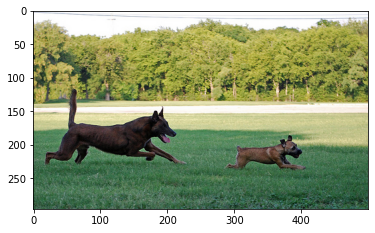

Greedy: two dogs play together in the grass


In [41]:
z = 18
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
#x=plt.imread(Directory_path+pic)
x=plt.imread('/content/drive/My Drive/Flickr8k_Dataset/Flicker8k_Dataset/2723477522_d89f5ac62b.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))